시계열 테이터로 설득하는 법

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pyplot #시각화
from matplotlib import dates # 시계열 데이터 다루기 위함
import statsmodels.api as sm # 회귀분석

In [13]:
# data = pd.read_csv('LGSS.csv')
df = pd.read_csv('health.csv')
df.columns = ['date', 'click']
df

,date,click
0,2019-01-01,36
1,2019-01-02,45
2,2019-01-03,41
3,2019-01-04,40
4,2019-01-05,40
...,...,...
360,2019-12-27,86
361,2019-12-28,80
362,2019-12-29,87
363,2019-12-30,88


# 시계열데이터의 조건
- 1년이상 수집 (계절성 필요)
- 일정한 간격으로 빠짐없이 데이터가 수집되어야 함
- 선형성 전제(선형성, 독립건, 등분산성, 정규성)

In [20]:
# 결측지가 없는지 확인해야 함. 연속성을 위해.
print(df['click'].isnull().sum())

# date가 시계열 데이터인지 확인하기
print(type(df['date'][0])) # 시계열이므로 날짜데이터로 바꿔야함

# 날짜데이터로 변환
df['date'] = pd.to_datetime(df['date'])
print(type(df['date'][0])) 
# timestamp는 시각을 의미하고 timedelta는 시간을 의미함

# time delta 예시
df['date'][1] - df['date'][0]


0
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


Timedelta('1 days 00:00:00')

# 탐색적 분석

<AxesSubplot:xlabel='date'>

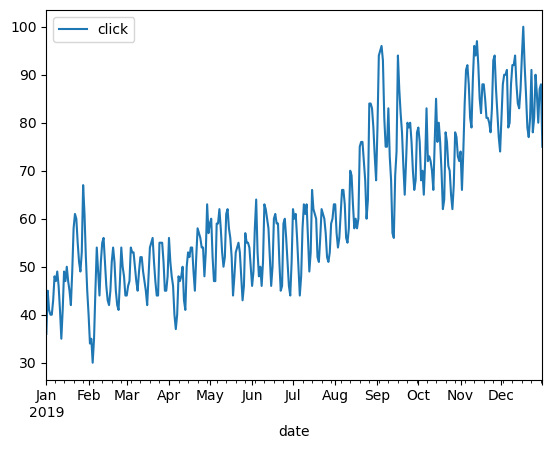

In [34]:
df.plot(x = 'date', y = 'click')
# 시계열 분석의 경우 이전 시간의 데이터를 참조한다. 
# 회귀의 경우 이전년도 이번 시간의 데이터를 참조한다.

## 일반회귀 분석

### 회귀분석을 위한 y절편, 기울기 구하기

In [33]:
x = range(len(df['date']))
y = df['click']

x = sm.add_constant(x) # 시계열분석을 할 떄, 기울기(베타와 에이)를 도출하는 것이 목표지만
# 회귀에서는 y절편도 뽑아야 함 
model = sm.OLS(y, x) # odinary least 
result = model.fit()
print(result.params)

const    39.057534
x1        0.126554
dtype: float64


In [36]:
# 회귀분석을 위해 y절편과 기울기 구하기
a,b = result.params # (y절편, 기울기)
print(result.params[0])
print(result.params[1])

39.05753424657536
0.126554267650158


### 회귀분석에 의한 예측값 구하기

In [41]:
# 일반항 구하기
length = len(df['date'])
prediction = [num*b+a for num in range(length)]
df['prediction'] = prediction
df.head(2)

,date,click,prediction
0,2019-01-01,36,39.057534
1,2019-01-02,45,39.184089


In [45]:
# 더 빠른 계산을 위한 코드
df1 = df.copy()
df1['date'] =  range(len(df1))
df1['prediction'] = df1['date'].apply(lambda x : b*x+a)
df1.head(2)

,date,click,prediction
0,0,36,39.057534
1,1,45,39.184089


<AxesSubplot:xlabel='date'>

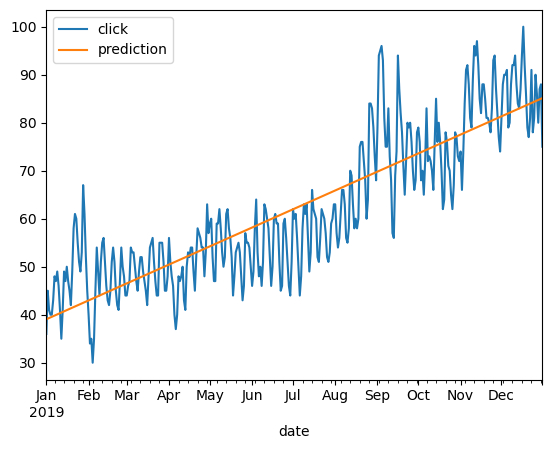

In [47]:
df.plot(x = 'date', y = ['click','prediction'])
# 하나의 주기 내에서 편차가 너무 크면 선형회귀분석에서 좋지 않다.
# 왜냐하면 mse가 과대평가되기 때문이다.
# 그래서 시계열 분석이 적합하다고 판단된다. 

# 근데 선형회귀에서 주기 고려 못하나??
# A : 할 수 있다. 날짜 데이터를 서열척도로 바꾸면 가능하다. 1,2,3,, ...
# (시계열데이터는 등간척도임)
# 그래서 주기 데이터도 서열척도나 명목척도로 치환할 수 있다. 

### MSE 구하기

In [52]:
mse = [(click-df['prediction'][num])**2 
       for num, click in enumerate(df['click'])]
# 실제값고 예측값의 차이를 제곱한 mse의 값을 리스트화 함
np.mean(mse)

64.7166329373385

### 요일을 서열척도로 변환해서 선형회귀 적용하기

In [60]:
# 일~토을 0~6으로 치환
yoll = [2,3,4,5,6,0,1] # 화요일부터 시작이기 때문에
season = []
season = [ yoil for repeat in range(len(df['click'])//len(yoll)) 
             for yoil in yoll]
season.append(2) # 7의 배수가 아니라 추가함
df['season'] = season
len(season)

365

In [61]:
df.head(2)

,date,click,prediction,season
0,2019-01-01,36,39.057534,2
1,2019-01-02,45,39.184089,3


# 그래프

<AxesSubplot:xlabel='date'>

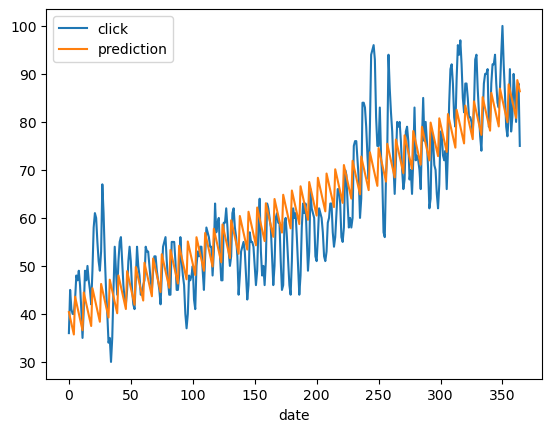

In [75]:
df['trend'] = df.index
x = df[['season', 'trend']]
y = df['click']

# 계수구하기
x = sm.add_constant(x)
model = sm.OLS(y, x)
result = model.fit()
# print(result.params) # const, season, trend
y_const, slope_season, slope_trend = result.params

# 서열척도에서 예측값 구하기
df['date'] =  range(len(df))
df['prediction'] = [slope_season*df['season'][n] + slope_trend*df['trend'][n] + y_const
                    for n in range(len(df['trend']))]
df.head(2)
df.plot(x = 'date', y = ['click','prediction'])

<AxesSubplot:xlabel='date'>

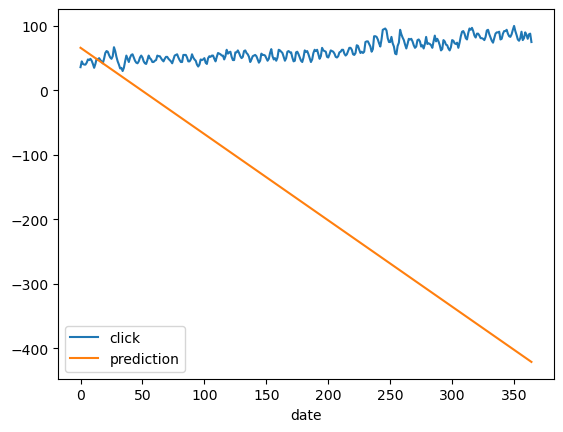

In [64]:
x = df['season']
y = df['click']

x = sm.add_constant(x) # 시계열분석을 할 떄, 기울기(베타와 에이)를 도출하는 것이 목표지만
# 회귀에서는 y절편도 뽑아야 함 
model = sm.OLS(y, x) # odinary least 
result = model.fit()
a,b = result.params

# 더 빠른 계산을 위한 코드
df1 = df.copy()
df1['date'] =  range(len(df1))
df1['prediction'] = df1['date'].apply(lambda x : b*x+a)
df1.head(2)
df1.plot(x = 'date', y = ['click','prediction'])

In [76]:
mse = [(click-df['prediction'][num])**2 
       for num, click in enumerate(df['click'])]
np.mean(mse)

# mse가 감소한 것을 알 수 있다.(68 -> 58)
# 만약 시간되 다른 변수가 있다면 선형회귀를 사용하는 게 맞다
# 시계열데이터는 1개의 변수에 대해 y축을 갖기 때문에
# 시계열분석에 적용할 수 없다.
# 그래서 다른 변수가 있다면 회귀분석을 사용해야 한다. 
# 다항회귀에 입력한 변수는 추세, 주기정보가 있어야 한다.
# 그래야 시계열을 반영했다고 볼 수 있다. 

58.05742898051807